In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import shutil
import tqdm
from itertools import cycle
import cv2
from PIL import Image

%matplotlib  inline

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
from google.colab import drive

if not os.path.exists('/content/drive'):
  drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Data loader class for images
class LoadImage(torch.utils.data.Dataset):
    def __init__(self, image_folder, transform=None):
        self.image_folder = image_folder
        self.transform = transform
        self.image_files = [f for f in os.listdir(image_folder) if os.path.isfile(os.path.join(image_folder, f))]

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_name = os.path.join(self.image_folder, self.image_files[idx])
        image = Image.open(img_name)
        label = int(self.image_files[idx][-5])  # Extract the last digit before the file extension as label

        if self.transform:
            image = self.transform(image)

        return image, label


# Calculate accuracy for a batch
def test_batch(outputs, labels):
    pred = labeling(outputs).reshape(-1,1)
    cor = torch.sum(pred==labels).item()
    acc = cor/labels.shape[0] * 100

    return acc

# Calculate accuracy for whole data
def test (model, dataloader, device):

    model.to(device)
    model.eval()  # Set the model to evaluation mode

    correct_predictions = 0
    total_predictions = 0

    with torch.no_grad():  # Disable gradient calculation for efficiency
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            predicted = labeling(outputs).squeeze() # Get the index of the max log-probability
            total_predictions += labels.size(0)
            correct_predictions += (predicted == labels).sum().item()

    accuracy = (correct_predictions / total_predictions) * 100
    return accuracy

# Labeling from logits to
def labeling(array):

    label = torch.where(array>=0.5,1,0)
    return label


# It will set parameters.requires_grad to true or false
def set_grad(model, does=True):
    for param in model.parameters():
        param.requires_grad = does

# Counting number of active parameters in the netwrok
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

# Evaluate outputs of the model
def model_eval(model, data_loader):
    features = []
    outputs = []
    loader = iter(data_loader)
    for _ in tqdm.trange(len(data_loader)):

        input,target = next(loader)
        # Extract features
        feature = model.feature_extractor(input).reshape(-1,)
        # Classify features
        output = model.classifier(feature)
        # Save all
        features.append(feature)
        outputs.append(output)

    # To torch tnesor
    features = torch.stack(features,dim=0).squeeze()
    outputs = torch.stack(outputs, dim=0)

    return features, outputs

## Data

In [ ]:
source_data_path = '/content/drive/MyDrive/ML_Aliyari/Project/HH/Source'
target_data_path = '/content/drive/MyDrive/ML_Aliyari/Project/HH/Target'

In [ ]:
from torchvision import transforms
# Define transforms for data augmentation and normalization
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images to 224x224
    transforms.ToTensor(),          # Convert PIL images to tensors
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize
])

In [ ]:
# Fix random seed for reproducibility
torch.manual_seed(69)

BATHC_SIZE = 8

# Load source data

source_dataset = LoadImage(source_data_path, transform=transform)
# Split dataset into train and test sets
train_size_s = int(0.8 * len(source_dataset))
test_size_s = len(source_dataset) - train_size_s
source_train, source_test = torch.utils.data.random_split(source_dataset, [train_size_s, test_size_s])
# Data Loaders
source_train_loader = torch.utils.data.DataLoader(source_train, batch_size=BATHC_SIZE, shuffle=True)
source_test_loader = torch.utils.data.DataLoader(source_test)


# Load target data

target_dataset = LoadImage(target_data_path, transform=transform)
# Split dataset into train and test sets
train_size_t = int(0.8 * len(target_dataset))
test_size_t = len(target_dataset) - train_size_t
target_train, target_test = torch.utils.data.random_split(target_dataset, [train_size_t, test_size_t])
# Data Loaders
target_train_loader = torch.utils.data.DataLoader(target_train, batch_size=BATHC_SIZE, shuffle=True)
target_test_loader = torch.utils.data.DataLoader(target_test)

In [ ]:
print(f'There are {len(source_train)} batches of {BATHC_SIZE} images in the source training set.')
print(f'There are {len(source_test)} images in the source test set.')
print(f'There are {len(target_train)} batches of {BATHC_SIZE} images in the target training set')
print(f'Threr are {len(target_test)} images in the target test set')
print(f'>>> All images are {224}x{224} pixels <<<')

There are 320 batches of 8 images in the source training set.
There are 80 images in the source test set.
There are 160 batches of 8 images in the target training set
Threr are 40 images in the target test set
>>> All images are 224x224 pixels <<<


## Source Train

### CNN Model

In [ ]:
# Define whole conv layer
class ConvLayer(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, padding,p):
        super(ConvLayer, self).__init__()
        self.conv = nn.Conv2d(
            in_channels=in_channels,
            out_channels=out_channels,
            kernel_size=kernel_size,
            stride=1,
            padding=padding
        )
        self.bn = nn.BatchNorm2d(out_channels)
        self.mp = nn.MaxPool2d(
            kernel_size=2,
            stride=2,
            padding=0
        )
        self.drop = nn.Dropout(p)

    def forward(self,x):
        x = self.conv(x)
        x = self.bn(x)
        x = self.mp(x)
        x = self.drop(x)
        return x

# Define a simple CNN model
class CNNNetwork(nn.Module):
    def __init__(self):
        super(CNNNetwork, self).__init__()
        self.feature_extractor = nn.Sequential(
            ConvLayer(3, 8, 13, 6, 0.2),
            ConvLayer(8, 16, 7, 3, 0.2),
            ConvLayer(16, 32, 5, 0, 0.2),
            ConvLayer(32, 32, 3, 0, 0.2),
        )
        # self.conv1 = ConvLayer(3, 8, 13, 6)
        # self.conv2 = ConvLayer(8, 16, 7, 3)
        # self.conv3 = ConvLayer(16, 32, 5, 0)
        # self.conv4 = ConvLayer(32, 32, 3, 0)
        self.classifier = nn.Sequential(
            nn.Linear(12*12*32,128),
            nn.ReLU(),
            nn.Linear(128,1),
            nn.Sigmoid()
        )
        # self.fc1 = nn.Linear(12*12*32, 128)
        # self.fc2 = nn.Linear(128, 1)



        self.best_acc = 0
        self.save_path = '/content/drive/MyDrive/ML_Aliyari/Project/HH/Source_model_weights.pth'
        self.patience = 6

    def forward(self, x):
        x = self.feature_extractor(x)
        x = x.view(-1, 12*12*32)
        x = self.classifier(x)
        return x

    def early_stopping(self,thing):

        '''
        Incase you wanted to use best loss
        just use "-loss" instead of val_acc

        '''
        # Early stopping
        if val_acc > self.best_acc:

            self.best_acc = val_acc
            self.best_epoch = epoch
            self.current_patience = 0

            # Save the model's weights
            torch.save(self.state_dict(), self.save_path)
            return False
        else:
            self.current_patience += 1
            # Check if the patience limit is reached
            if self.current_patience >= self.patience:
                print("Early stopping triggered!")
                return True


### Train model

In [ ]:
model = CNNNetwork().to(device)
model.pacience =  20

# Define loss function and optimizer
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


In [ ]:
from torchsummary import summary
summary(model, (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 8, 224, 224]           4,064
       BatchNorm2d-2          [-1, 8, 224, 224]              16
         MaxPool2d-3          [-1, 8, 112, 112]               0
           Dropout-4          [-1, 8, 112, 112]               0
         ConvLayer-5          [-1, 8, 112, 112]               0
            Conv2d-6         [-1, 16, 112, 112]           6,288
       BatchNorm2d-7         [-1, 16, 112, 112]              32
         MaxPool2d-8           [-1, 16, 56, 56]               0
           Dropout-9           [-1, 16, 56, 56]               0
        ConvLayer-10           [-1, 16, 56, 56]               0
           Conv2d-11           [-1, 32, 52, 52]          12,832
      BatchNorm2d-12           [-1, 32, 52, 52]              64
        MaxPool2d-13           [-1, 32, 26, 26]               0
          Dropout-14           [-1, 32,

In [ ]:
(f'There are {count_parameters(model)} trainable parameters in this model')

'There are 622689 trainable parameters in this model'

In [ ]:
# Train loop
num_epochs = 30
best_accuracy = 0
train_loss_list = []
val_acc_list  = []
train_acc_list = []

for epoch in range(num_epochs):
    model.train()
    loader = iter(source_train_loader)
    pbar = tqdm.trange(len(source_train_loader))
    acc_list = []
    loss_list  = []
    for i in pbar:
        inputs, labels = next(loader)
        inputs, labels = inputs.to(device), labels.to(device)
        labels = labels.reshape(-1,1)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels.float())
        loss.backward()
        optimizer.step()

        # Calculate accuracy
        pred = labeling(outputs)
        cor = torch.sum(pred==labels).item()
        acc = test_batch(outputs,labels)
        acc_list.append(acc)

        # Calculate loss
        loss_list.append(loss.item())

        pbar.set_description(f'Epoch {epoch+1}/{num_epochs}, Loss: {np.mean(loss_list):.4f}, Accuracy: {np.mean(acc_list):.2f}')

    # Calculate validation accuracy
    val_acc = test(model,source_test_loader, device)
    val_acc_list.append(val_acc)
    print(f'Test accuracy is: {val_acc:0.2f}')

    train_acc_list.append(np.mean(acc_list))
    train_loss_list.append(np.mean(loss_list))

    # Early stopping
    do_break = model.early_stopping(val_acc)
    if do_break:
        break



Epoch 1/30, Loss: 0.6581, Accuracy: 63.44: 100%|██████████| 40/40 [00:05<00:00,  7.34it/s]


Test accuracy is: 50.00


Epoch 2/30, Loss: 0.4405, Accuracy: 78.75: 100%|██████████| 40/40 [00:05<00:00,  7.24it/s]


Test accuracy is: 70.00


Epoch 3/30, Loss: 0.4184, Accuracy: 80.31: 100%|██████████| 40/40 [00:05<00:00,  7.31it/s]


Test accuracy is: 50.00


Epoch 4/30, Loss: 0.4102, Accuracy: 81.56: 100%|██████████| 40/40 [00:06<00:00,  6.57it/s]


Test accuracy is: 67.50


Epoch 5/30, Loss: 0.3599, Accuracy: 83.44: 100%|██████████| 40/40 [00:05<00:00,  7.27it/s]


Test accuracy is: 50.00


Epoch 6/30, Loss: 0.3615, Accuracy: 83.75: 100%|██████████| 40/40 [00:05<00:00,  7.28it/s]


Test accuracy is: 51.25


Epoch 7/30, Loss: 0.3323, Accuracy: 84.06: 100%|██████████| 40/40 [00:05<00:00,  6.98it/s]


Test accuracy is: 50.00


Epoch 8/30, Loss: 0.3563, Accuracy: 81.25: 100%|██████████| 40/40 [00:05<00:00,  7.49it/s]


Test accuracy is: 73.75


Epoch 9/30, Loss: 0.3299, Accuracy: 81.56: 100%|██████████| 40/40 [00:05<00:00,  6.97it/s]


Test accuracy is: 76.25


Epoch 10/30, Loss: 0.3118, Accuracy: 84.69: 100%|██████████| 40/40 [00:05<00:00,  7.81it/s]


Test accuracy is: 81.25


Epoch 11/30, Loss: 0.2744, Accuracy: 84.69: 100%|██████████| 40/40 [00:05<00:00,  6.87it/s]


Test accuracy is: 80.00


Epoch 12/30, Loss: 0.2556, Accuracy: 86.25: 100%|██████████| 40/40 [00:05<00:00,  7.70it/s]


Test accuracy is: 56.25


Epoch 13/30, Loss: 0.2552, Accuracy: 87.19: 100%|██████████| 40/40 [00:06<00:00,  6.20it/s]


Test accuracy is: 52.50


Epoch 14/30, Loss: 0.2157, Accuracy: 89.38: 100%|██████████| 40/40 [00:05<00:00,  7.47it/s]


Test accuracy is: 50.00


Epoch 15/30, Loss: 0.2328, Accuracy: 89.06: 100%|██████████| 40/40 [00:05<00:00,  6.84it/s]


Test accuracy is: 50.00


Epoch 16/30, Loss: 0.2102, Accuracy: 90.62: 100%|██████████| 40/40 [00:05<00:00,  7.84it/s]


Test accuracy is: 50.00
Early stopping triggered!


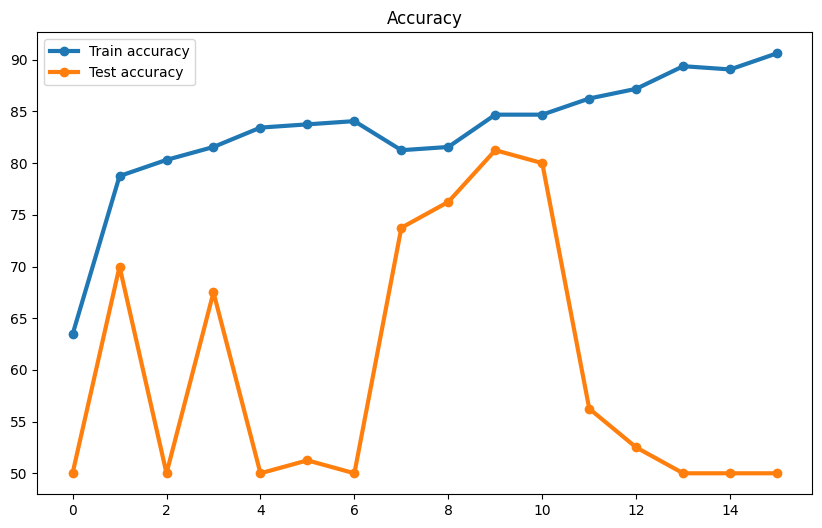

In [ ]:
plt.figure(figsize=(10,6))
plt.plot(train_acc_list, label='Train accuracy', linewidth=3, marker='o')
plt.plot(val_acc_list, label='Test accuracy', linewidth=3, marker='o')
plt.title('Accuracy')
plt.legend()

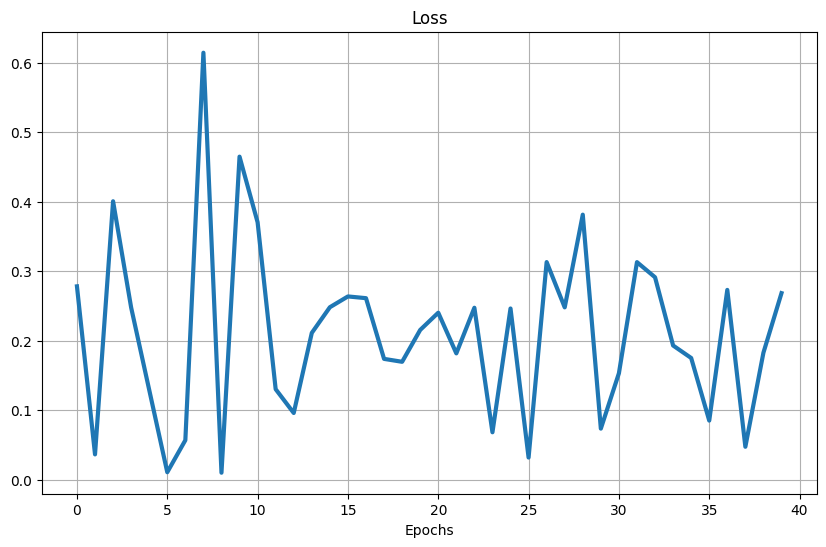

In [ ]:
plt.figure(figsize=(10,6))
plt.plot(loss_list, linewidth=3)
plt.title('Loss')
plt.xlabel('Epochs')
plt.grid()

In [ ]:
print(f'Best Train accuracy: {train_acc_list[-1]:.1f}%')
print(f'Best Validation accuracy: {val_acc_list[-1]:.1f}%')
print(f'The best epoch is {model.best_epoch+1}')

Best Train accuracy: 90.6%
Best Validation accuracy: 50.0%
The best epoch is 10


## Discriminator

### Train discriminator


In [ ]:
import copy

In [ ]:
source_model = CNNNetwork().to(device)
source_model.load_state_dict(torch.load(source_model.save_path, map_location=device))
source_model.eval()
set_grad(source_model, False)

source_clone = copy.deepcopy(source_model)
source_model = source_model.feature_extractor

target_model = CNNNetwork().to(device)
target_model.load_state_dict(torch.load(target_model.save_path, map_location=device)) # Load model weights
target_model = target_model.feature_extractor


BATCH_SIZE = 40
hb = BATCH_SIZE//2
LEARNING_RATE = 0.001

# Discriminator  network
discri  = nn.Sequential(
    nn.Flatten(),
    nn.Linear(12*12*32,512),
    nn.ReLU(),
    nn.Linear(512,16),
    nn.ReLU(),
    nn.Linear(16,1),
    nn.Sigmoid()
).to(device)

# Define loss function and optimizer
criterion = nn.BCELoss()
discri_optim = optim.Adam(discri.parameters(), lr=LEARNING_RATE)
target_optim = optim.Adam(target_model.parameters(), lr=LEARNING_RATE)

In [ ]:
# Train
N_EPOCHS = 30
iterations = 100
disc_iter = 1
targ_iter = 5
best_accuracy = 0
td_loss_list = []
td_acc_list  = []
old_dict = target_model.state_dict()

for epoch in range(1,N_EPOCHS+1):

    batch_iterator = zip(cycle(source_train_loader), cycle(target_train_loader))

    for _ in tqdm.trange(iterations,leave=False):
    # for _ in range(iterations):

        # Setting trainable and untrainable models
        set_grad(target_model,False)
        set_grad(discri,True)


        total_loss = 0
        total_acc = 0

        # Train discriminator
        for _ in range(disc_iter):
            # Load inputs
            (source_x,_), (target_x,_) = next(batch_iterator)
            source_x, target_x = source_x.to(device), target_x.to(device)

            # Feature FP
            source_feature = source_model(source_x)

            target_feature = target_model(target_x)

            discri_x = torch.cat([source_feature, target_feature], dim=0).to(device)
            discri_y = torch.cat(
                [
                    torch.ones(source_x.shape[0], dtype=torch.float32, device=device),
                    torch.zeros(target_x.shape[0], dtype=torch.float32, device=device)
                ]
            ).to(device)

            preds = discri(discri_x).squeeze()
            loss = criterion(preds, discri_y)

            discri_optim.zero_grad()
            loss.backward()
            discri_optim.step()

            total_loss += loss.item()
            # They all should become ones
            total_acc += ((preds>0.5).long() == discri_y.long()).float().mean()

        set_grad(target_model, True)
        set_grad(discri, False)

        for _ in range(targ_iter):
            # Load inputs
            _, (target_x,_) = next(batch_iterator)
            target_x = target_x.to(device)

            # Feature FP
            target_feature = target_model(target_x)

            discrit_y = torch.ones(target_x.shape[0], dtype=torch.float32, device=device)

            predss = discri(target_feature).squeeze()
            loss = criterion(predss, discrit_y)

            target_optim.zero_grad()
            loss.backward()
            target_optim.step()

    mean_loss = total_loss / iterations
    mean_acc = total_acc / iterations

    td_loss_list.append(mean_loss)
    td_acc_list.append(mean_acc)

    tqdm.tqdm.write(f'Epoch {epoch}/{N_EPOCHS}, Loss: {mean_loss:.4f}, Accuracy: {mean_acc:.2f}')
    new_dict = target_model.state_dict()
    old_dict = new_dict.copy()
    source_clone.feature_extraction = target_model
    torch.save(source_clone.state_dict(), '/content/drive/MyDrive/ML_Aliyari/Project/HH/target_model.pt')


Epoch 1/30, Loss: 0.0105, Accuracy: 0.00


Epoch 2/30, Loss: 0.0057, Accuracy: 0.00


Epoch 3/30, Loss: 0.0065, Accuracy: 0.00


Epoch 4/30, Loss: 0.0059, Accuracy: 0.01


Epoch 5/30, Loss: 0.0059, Accuracy: 0.01


Epoch 6/30, Loss: 0.0067, Accuracy: 0.01


Epoch 7/30, Loss: 0.0062, Accuracy: 0.00


Epoch 8/30, Loss: 0.0053, Accuracy: 0.01


Epoch 9/30, Loss: 0.0068, Accuracy: 0.01


Epoch 10/30, Loss: 0.0050, Accuracy: 0.01


Epoch 11/30, Loss: 0.0057, Accuracy: 0.01


Epoch 12/30, Loss: 0.0070, Accuracy: 0.01


Epoch 13/30, Loss: 0.0042, Accuracy: 0.01


Epoch 14/30, Loss: 0.0043, Accuracy: 0.01


Epoch 15/30, Loss: 0.0060, Accuracy: 0.01


Epoch 16/30, Loss: 0.0057, Accuracy: 0.01


Epoch 17/30, Loss: 0.0069, Accuracy: 0.01


Epoch 18/30, Loss: 0.0081, Accuracy: 0.01


Epoch 19/30, Loss: 0.0052, Accuracy: 0.01


Epoch 20/30, Loss: 0.0070, Accuracy: 0.01


Epoch 21/30, Loss: 0.0044, Accuracy: 0.01


Epoch 22/30, Loss: 0.0035, Accuracy: 0.01


Epoch 23/30, Loss: 0.0037, Accuracy: 0.01


Epoch 24/30, Loss: 0.0050, Accuracy: 0.01


Epoch 25/30, Loss: 0.0037, Accuracy: 0.01


Epoch 26/30, Loss: 0.0058, Accuracy: 0.01


Epoch 27/30, Loss: 0.0033, Accuracy: 0.01


Epoch 28/30, Loss: 0.0035, Accuracy: 0.01


Epoch 29/30, Loss: 0.0060, Accuracy: 0.01


Epoch 30/30, Loss: 0.0041, Accuracy: 0.01


In [ ]:
print('The output of the discriminator:')
print(predss.cpu().detach().numpy())

The output of the discriminator:
[0.08952896 0.07534419 0.35254815 0.07778192 0.4134319  0.24437957
 0.5216184  0.7009291 ]


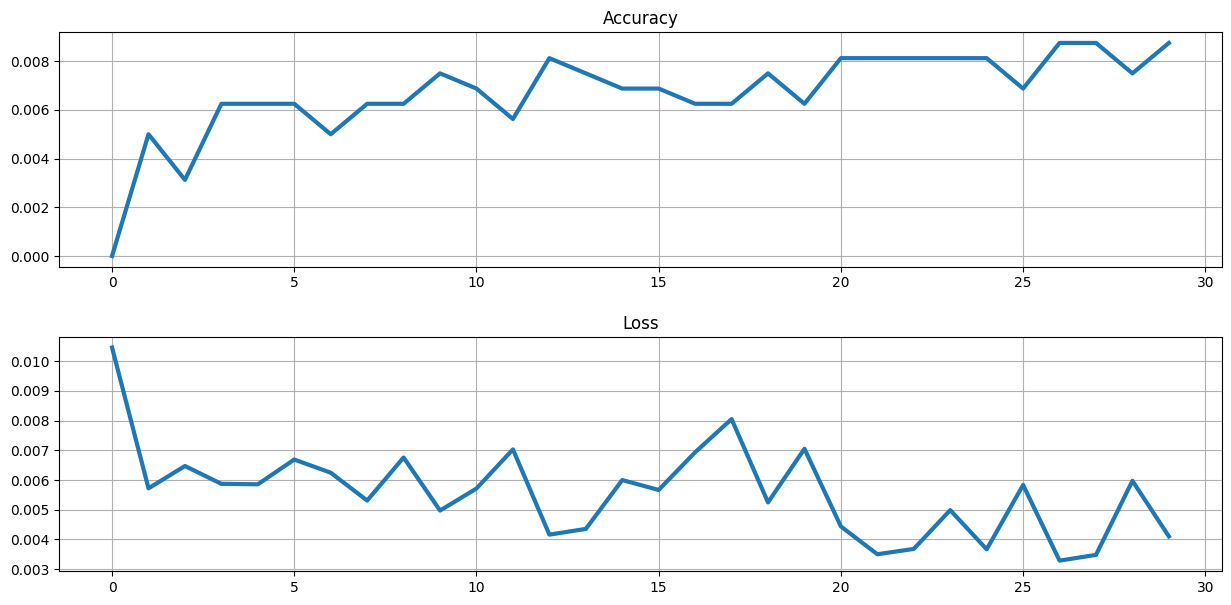

In [ ]:
fig, (ax1,ax2) = plt.subplots(2,1,figsize=(15,7))

ax1.plot([i.cpu().detach().numpy() for i in td_acc_list],
         linewidth = 3)
ax1.set_title('Accuracy')
ax1.grid()

ax2.plot(td_loss_list,
         linewidth = 3)
ax2.set_title('Loss')
ax2.grid()

plt.subplots_adjust(hspace=0.3)

## Evaluation

Import model weights

In [ ]:
import collections

In [ ]:
# Source model
source_model = CNNNetwork().to(device)
source_model.load_state_dict(torch.load(source_model.save_path, map_location=device)) # Loading weights
source_model.eval();

# Target model
target_model = CNNNetwork().to(device)
target_model.save_path = '/content/drive/MyDrive/ML_Aliyari/Project/HH/target_model.pt'
sd = torch.load(target_model.save_path, map_location=device)
keys = ['feature_extractor.0.conv.weight', 'feature_extractor.0.conv.bias', 'feature_extractor.0.bn.weight', 'feature_extractor.0.bn.bias', 'feature_extractor.0.bn.running_mean', 'feature_extractor.0.bn.running_var', 'feature_extractor.0.bn.num_batches_tracked', 'feature_extractor.1.conv.weight', 'feature_extractor.1.conv.bias', 'feature_extractor.1.bn.weight', 'feature_extractor.1.bn.bias', 'feature_extractor.1.bn.running_mean', 'feature_extractor.1.bn.running_var', 'feature_extractor.1.bn.num_batches_tracked', 'feature_extractor.2.conv.weight', 'feature_extractor.2.conv.bias', 'feature_extractor.2.bn.weight', 'feature_extractor.2.bn.bias', 'feature_extractor.2.bn.running_mean', 'feature_extractor.2.bn.running_var', 'feature_extractor.2.bn.num_batches_tracked', 'feature_extractor.3.conv.weight', 'feature_extractor.3.conv.bias', 'feature_extractor.3.bn.weight', 'feature_extractor.3.bn.bias', 'feature_extractor.3.bn.running_mean', 'feature_extractor.3.bn.running_var', 'feature_extractor.3.bn.num_batches_tracked', 'classifier.0.weight', 'classifier.0.bias', 'classifier.2.weight', 'classifier.2.bias']
target_state_dict = collections.OrderedDict((key, sd[key]) for key in keys)
target_model.load_state_dict(target_state_dict) # Loading weights
target_model.eval();

Import data

In [ ]:
# Source test
stf, sto = model_eval(source_model, source_test_loader)
stf = stf.detach().numpy()
sto =  sto.detach().numpy()

# Target test
ttf, tto = model_eval(target_model, target_test_loader)
ttf = ttf.detach().numpy()
tto = tto.detach().numpy()


100%|██████████| 40/40 [00:12<00:00,  3.28it/s]


### Target Performance

In [ ]:
# Performace on source model
source_acc_test = test(source_model, target_test_loader, device)
source_acc_train = test(source_model, target_train_loader, device)

# Performace on target model
target_acc_test = test(target_model, target_test_loader, device)
target_acc_train = test(target_model, target_train_loader, device)

In [ ]:
print('MODEL ACCURACIES ON TARGET DATA')
print(f'Source model & Train data: {source_acc_train:.1f}%')
print(f'Source model & Testn data: {source_acc_test:.1f}%')
print(f'Target model & Train data: {target_acc_train:.1f}%')
print(f'Target model & Test data: {target_acc_test:.1f}%')

MODEL ACCURACIES ON TARGET DATA
Source model & Train data: 83.1%
Source model & Testn data: 80.0%
Target model & Train data: 83.1%
Target model & Test data: 80.0%


### Source Performances

In [ ]:
# Performace on source model
source_acc_test = test(source_model, source_test_loader, device)
source_acc_train = test(source_model, source_train_loader, device)

# Performace on target model
target_acc_test = test(target_model, source_test_loader, device)
target_acc_train = test(target_model, source_train_loader, device)

In [ ]:
print('MODEL ACCURACIES ON SOURCE DATA')
print(f'Source model & Train data: {source_acc_train:.1f}%')
print(f'Source model & Testn data: {source_acc_test:.1f}%')
print(f'Target model & Train data: {target_acc_train:.1f}%')
print(f'Target model & Test data: {target_acc_test:.1f}%')

MODEL ACCURACIES ON SOURCE DATA
Source model & Train data: 85.3%
Source model & Testn data: 81.2%
Target model & Train data: 85.3%
Target model & Test data: 81.2%


### Visualization

Dimention
 reduction

In [ ]:
from sklearn.manifold import TSNE

In [ ]:
tsne_s2 = TSNE(n_components=2, random_state=69)
tsne_s3 = TSNE(n_components=3, random_state=69)
tsne_t2 = TSNE(n_components=2, random_state=69)
tsne_t3 = TSNE(n_components=3, random_state=69)

In [ ]:
stf2 = tsne_s2.fit_transform(stf)
stf3 = tsne_s3.fit_transform(stf)
ttf2 = tsne_t2.fit_transform(ttf)
ttf3 = tsne_t3.fit_transform(ttf)

Visualizing reduced data

In [ ]:
# labels
y_s_test = []
y_t_test = []

for _, label in source_test_loader:
    y_s_test.append(label)
for _, label in target_test_loader:
    y_t_test.append(label)

y_s_test = torch.cat(y_s_test).numpy()
y_t_test = torch.cat(y_t_test).numpy()

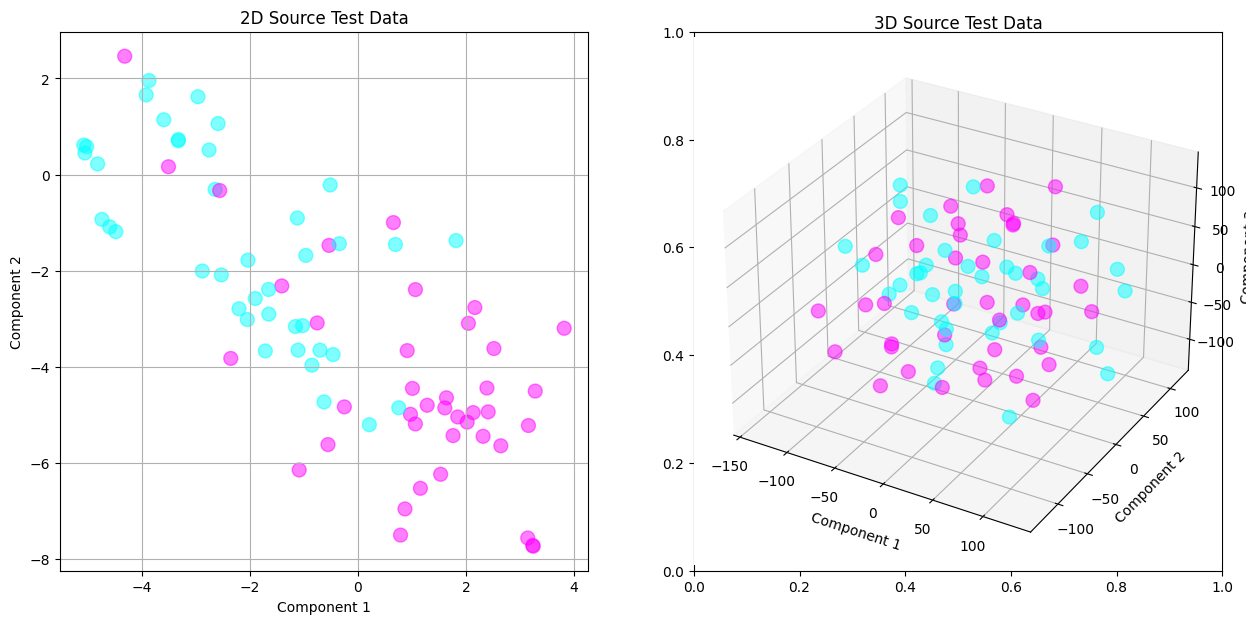

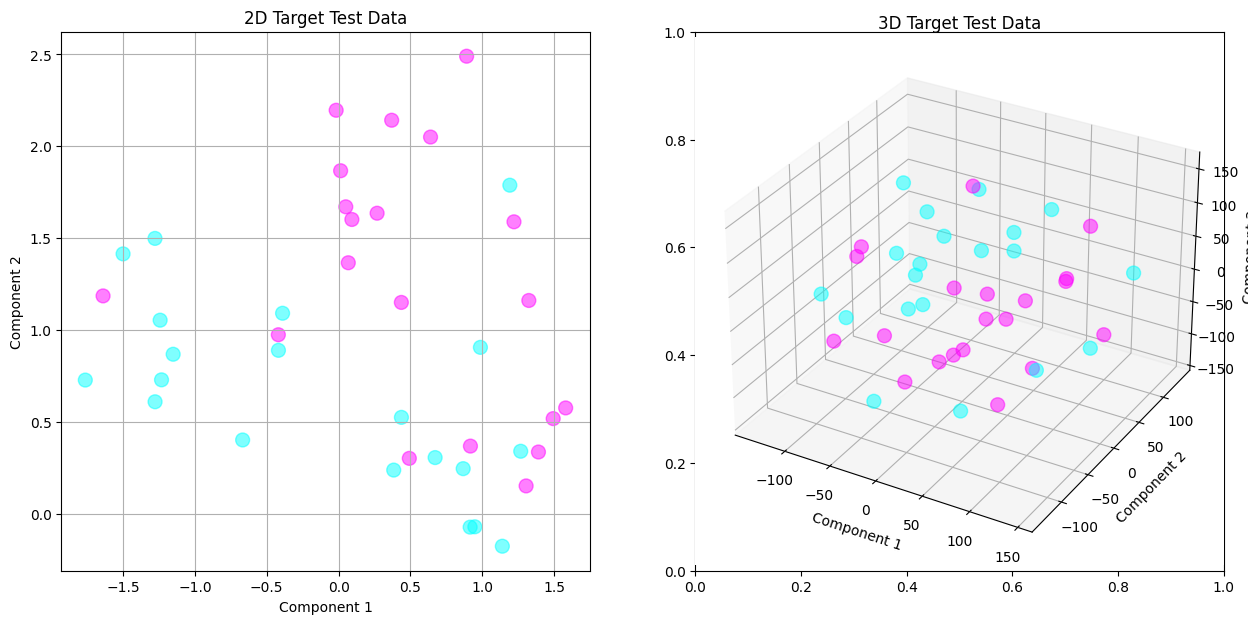

In [ ]:
# Source
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(15,7))
ax1.scatter(
    stf2[:,0],
    stf2[:,1],
    c = y_s_test,
    cmap = 'cool',
    s =  100,
    alpha = .5
)
ax1.set_title('2D Source Test Data')
ax1.set_xlabel('Component 1')
ax1.set_ylabel('Component 2')
ax1.grid()

ax2 = fig.add_subplot(1, 2, 2, projection='3d')
ax2.scatter(
    stf3[:, 0],
    stf3[:, 1],
    stf3[:, 2],
    c = y_s_test,
    cmap = 'cool',
    s = 100,
    alpha =.5
)
ax2.set_title('3D Source Test Data')
ax2.set_xlabel('Component 1')
ax2.set_ylabel('Component 2')
ax2.set_zlabel('Component 3')

plt.savefig('source_test.png')

# Target
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(15,7))
ax1.scatter(
    ttf2[:,0],
    ttf2[:,1],
    c = y_t_test,
    cmap = 'cool',
    s =  100,
    alpha = .5
)
ax1.set_title('2D Target Test Data')
ax1.set_xlabel('Component 1')
ax1.set_ylabel('Component 2')
ax1.grid()

ax2 = fig.add_subplot(1, 2, 2, projection='3d')
ax2.scatter(
    ttf3[:, 0],
    ttf3[:, 1],
    ttf3[:, 2],
    c = y_t_test,
    cmap = 'cool',
    s = 100,
    alpha =.5
)
ax2.set_title('3D Target Test Data')
ax2.set_xlabel('Component 1')
ax2.set_ylabel('Component 2')
ax2.set_zlabel('Component 3')

plt.savefig('target_test.png')

#